<a href="https://colab.research.google.com/github/Emnatriki/ESPITA_formation_DL/blob/main/D%C3%A9tection_du_cancer_(cancer_des_poumons).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

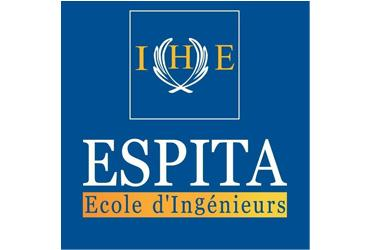

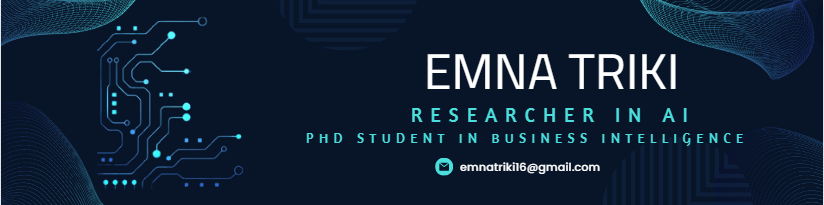

# Préparation de l'Environnement

In [ ]:
pip install numpy

In [ ]:
pip install pandas

In [ ]:
pip install tensorflow

In [ ]:
pip install matplotlib

In [ ]:
 pip install seaborn #visualisation des courbes

In [ ]:
pip install opencv-python

# **Détection du cancer  des poumons**

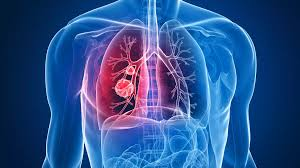

Dataset: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images/data

# 1- importation des bibliothèques

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# 2- Importation Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=("/content/drive/MyDrive/cancer des poumons")

In [ ]:
train_path_str = '/content/drive/MyDrive/cancer des poumons/train'

In [ ]:
val_path_str = '/content/drive/MyDrive/cancer des poumons/valid'

In [ ]:
test_path_str = '/content/drive/MyDrive/cancer des poumons/test'

In [ ]:
import os
test_classes = os.listdir(test_path_str)

# 3- Pré-processing data

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout
#Conv2D :couche de convolution 2D pour extraire des caractéristiques des images
#Dense : couche de connexion
#maxpooling2D :  couche de sous échantillonnage qui réduit les dimensions
#Flattern: couche qui aplatit les données en entrées en un vecteur
#BatchNormalization : couche qui normalise les activations de la couche précédente
#Dropout : couche de régulation pour prévenir le surapprentissage

In [ ]:
from tensorflow.keras.models import Sequential # Sequential : API pour créer des modèles en expilant des couches
from tensorflow.keras.applications import VGG16 # VGG16 : modèle de réseau de neurones convolutif pré-entainé
from tensorflow.keras.preprocessing.image import ImageDataGenerator # ImageDataGenerator : classe pour augmenter les données d'images
from tensorflow.keras.applications.resnet import preprocess_input # preprocess_input : fonction de prétraitement pour les modèles ResNet

In [ ]:
import matplotlib.pyplot as plt # matplotlib : bibliothèque pour la création de visualisation
import cv2 as cv # OpenCV bibliotèque de vision par ordinateur

In [ ]:
# Importation des outils de Scikit-learn pour le traitement et l'évaluation des données
from sklearn.utils import shuffle  # shuffle :fonction pour mélanger les ensembles de données
from keras.utils import to_categorical # to_categorical : fonction pour convertir des vecteurs de classe en matrice de classe binaires
from sklearn.metrics import confusion_matrix, classification_report #fonctions pour évaluer les modèle de classification

In [ ]:
# definition de la forme des entrées de model
input_shape = (224, 224, 3) #les images sont 224x224 pixels avec 3 canaux de couleur RGB

In [ ]:
# definition du nombre de classe de sortie
num_classe = 4

In [ ]:
#configuration du générateur d'image pour l'environnement avec augmentation des données
trainGenerator = ImageDataGenerator(
    preprocessing_function = preprocess_input , #prétraitement des images
    rotation_range = 10, # rotation aléatoire des images dans une plage de 10 degré
    width_shift_range = 0.3,# translation horizontal aléatoire des images dans une plage de 30 degrés
    height_shift_range = 0.3, # translation vertical aléatoire des images dans une plage de 30 degrés
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip =True,
    vertical_flip =True,
    dtype = 'float32'
)

In [ ]:
valGenerator = ImageDataGenerator(
    preprocessing_function = preprocess_input ,

    dtype = 'float32'
)

In [ ]:
testGenerator = ImageDataGenerator(
    preprocessing_function = preprocess_input ,

    dtype = 'float32'
)

In [ ]:
train_data = trainGenerator.flow_from_directory(
    train_path_str ,
    target_size =(224,224), #taille d'image
    batch_size = 16,
    class_mode ='categorical'
)

Found 613 images belonging to 4 classes.


In [ ]:
val_data = valGenerator.flow_from_directory(
    val_path_str ,
    target_size =(224,224),
    batch_size = 16,
    class_mode ='categorical'
)

Found 72 images belonging to 4 classes.


In [ ]:
test_data = testGenerator.flow_from_directory(
    test_path_str ,
    target_size =(224,224),
    batch_size = 16,
    class_mode ='categorical'
)

Found 315 images belonging to 4 classes.


In [ ]:
VGG16_model = VGG16(
    include_top = False, #ne pas inclure des couches de classification finales
    weights = "imagenet", #utilisation les poids pré-entrainées sur le dataset
    input_shape = input_shape
)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in VGG16_model.layers:
   layer.trainable = False

# 4- Création de modèle

In [ ]:
from keras import activations
#création d'un modèle séquentiel
model = Sequential()

#ajout du modèle VGG pré-entainé sans la couche fully connected
model.add(VGG16_model)

#AJOUTER une couche de normalisation par lots pour améliorer la stabilité et la vitesse
model.add(BatchNormalization())


#ajouter une couche de pooling max pour réduire la dimension des données
model.add(MaxPooling2D((2,2)))


#ajouter les données à l'entrée pour fully connected
model.add(Flatten())

#première couche fully connected avec 1024 neurones activés par la fonction Relu
model.add(Dense(1024, activation='relu'))

model.add(Dropout(0.3)) #ajout d'une couche de régularisation avec taux 30%

#deuxième couche fully connected avec 512 neurones activés par la fonction Relu
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.3)) #ajout d'une couche de régularisation avec taux 30%

#troisième couche fully connected avec 128 neurones activés par la fonction Relu
model.add(Dense(128, activation='relu'))

#couche de sortie avec un nombre de neurones égal au nombre de classe, activée par softmax
model.add(Dense(num_classe, activation ='softmax'))

model.summary() #affichage de model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [ ]:
from logging import log
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5) , #Arrête l'entrainement si la métrique surveillée ne s'améliore plus après 5 epoches
    tf.keras.callbacks.ModelCheckpoint('model.h5' , save_best_only = True ) , #sauvegarder  la modèle dans un fichiers 'model.h5' si la performance sur les données de
    tf.keras.callbacks.TensorBoard (log_dir='logs') #Enregistre les logs pour visualiser les métriques d'entrainement dans TensorBoard
]

In [ ]:
# Compile the model
model.compile(optimizer='adam', # Choose an optimizer like 'adam' or 'sgd'
              loss='categorical_crossentropy', # Use appropriate loss function based on your task (e.g., 'categorical_crossentropy' for multi-class classification)
              metrics=['accuracy']) # Specify evaluation metrics

# Now you can train the model
results = model.fit(train_data,validation_data=val_data,epochs=100,verbose = 1)

Epoch 1/100
39/39 [==============================] - 193s 5s/step - loss: 1.8293 - accuracy: 0.4356 - val_loss: 1.4984 - val_accuracy: 0.4861
Epoch 2/100
39/39 [==============================] - 14s 351ms/step - loss: 1.2124 - accuracy: 0.5057 - val_loss: 1.3700 - val_accuracy: 0.4583
Epoch 3/100
39/39 [==============================] - 14s 351ms/step - loss: 1.1064 - accuracy: 0.5302 - val_loss: 1.0999 - val_accuracy: 0.5278
Epoch 4/100
39/39 [==============================] - 13s 342ms/step - loss: 1.0031 - accuracy: 0.5514 - val_loss: 0.9895 - val_accuracy: 0.4722
Epoch 5/100
39/39 [==============================] - 14s 359ms/step - loss: 0.9227 - accuracy: 0.5791 - val_loss: 0.9712 - val_accuracy: 0.4861
Epoch 6/100
39/39 [==============================] - 14s 352ms/step - loss: 0.8745 - accuracy: 0.6215 - val_loss: 0.8961 - val_accuracy: 0.5417
Epoch 7/100
39/39 [==============================] - 14s 352ms/step - loss: 0.8667 - accuracy: 0.6330 - val_loss: 0.9520 - val_accuracy: 0

In [ ]:
loss, acc = model.evaluate(test_data,verbose = 1)

20/20 [==============================] - 120s 6s/step - loss: 0.4809 - accuracy: 0.8540


In [ ]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)

20/20 [==============================] - 3s 145ms/step
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       120
           1       0.20      0.22      0.21        51
           2       0.26      0.22      0.24        54
           3       0.23      0.19      0.21        90

    accuracy                           0.32       315
   macro avg       0.28      0.28      0.28       315
weighted avg       0.31      0.32      0.31       315

